In [1]:
import os
import sys
import numpy as np
from pathlib import Path

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent))

# Import the module from the custom library
from src.architectures.sequential import Sequential
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, TrainingArguments, layers, activations, loss_functions, optimizers, metrics, callbacks

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'sine_approximator')

In [3]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 3e-04 # Learning rate for the optimizer
batch_size = 32 # Number of samples to use for each batch
epochs = 300 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
def generate_sine_dataset(n_samples: int, noise: float = 0.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Method to generate a dataset of samples and targets of a sine function
    
    Parameters: 
    - n_samples (int): Number of samples to generate
    - noise float: Standard deviation of the Gaussian noise. Default is 0 (no noise)
    
    Returns:
    - tuple[np.ndarray, np.ndarray]: Features and target of the dataset
    """

    # Generate random samples
    X = np.random.uniform(-2*np.pi, 2*np.pi, (n_samples, 1)).astype(np.float32)

    # Compute the target
    y = np.sin(X) + np.random.normal(0, noise, (n_samples, 1)).astype(np.float32)
    
    # Return the dataset
    return X, y

In [6]:

# Generate the synthetic dataset of a sine function with some gaussian noise
X, y = generate_sine_dataset(n_samples, noise=data_noise)

# Convert the dataset to Tensor objects
X, y = Tensor(X), Tensor(y)

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data((X, y), train_test_split_pct, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data((X_train, y_train), train_valid_split, shuffle=True)[0]

# Print the dataset information
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (640, 1) (640, 1)
Validation set: (160, 1) (160, 1)
Testing set: (200, 1) (200, 1)


### Data visualization

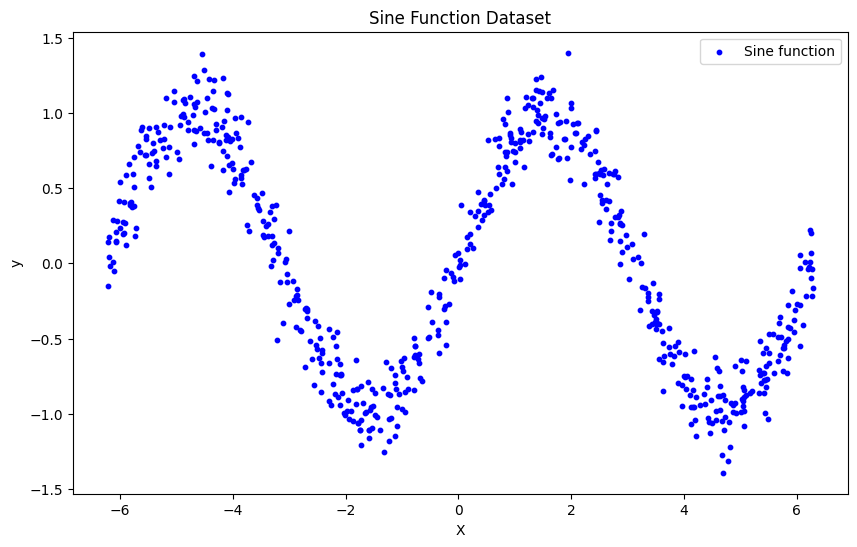

In [7]:
data_analysis.plot_data(
    datasets = [
        {'points': np.array(list(zip(X_train.data, y_train.data))), 'label': "Sine function", 'color': "blue", 'size': 10, 'plot_type': 'scatter'},
    ],
    title = "Sine Function Dataset",
    xlabel = "X",
    ylabel = "y"
)

### Building the model

In [8]:
# Create the model
model = Sequential(
    name = "Sine Function Approximator",
    modules = [
        layers.Dense(num_units=128, activation=activations.Tanh()),
        layers.Dense(num_units=64, activation=activations.Tanh()),
        layers.Dense(num_units=32, activation=activations.Tanh()),
        layers.Dense(num_units=1)
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(
    learning_rate = learning_rate,
    weight_decay = 0.01
)

# Initialize the error function
loss_fn = loss_functions.MeanSquareError()

### Initializing the model

In [9]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    model(X_train[:batch_size])

In [10]:
# Display the model summary
model.summary()
model.modules.summary()


Sine Function Approximator

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
sine_function_approximator.modules (ModuleList)        (32, 1)             10625               
Total trainable parameters: 10625
-----------------------------------------------------------------------------------------------

sine_function_approximator.modules

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
module_list.0 (Dense)                                  (32, 128)           256                 
-----------------------------------------------------------------------------------------------
module_list.1 (Dense)                                  (32, 64)            8256                
------------------------------------

### Training the model

In [ ]:
# Create the training arguments
train_arguments = TrainingArguments(
    train_data = {'x': X_train},
    valid_data = {'x': X_valid},
    y_train = y_train,
    y_valid = y_valid,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = epochs,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor="val_loss", patience=10)]
)

# Fit the model
history = model.fit(train_arguments)

Epoch 1/300 --> loss: 0.47677 - mean absolute error: 0.60435 | Val loss: 0.4859 - Val mean absolute error: 0.6258      
Epoch 2/300 --> loss: 0.38264 - mean absolute error: 0.54392 | Val loss: 0.37391 - Val mean absolute error: 0.54183    
Epoch 3/300 --> loss: 0.2779 - mean absolute error: 0.45933 | Val loss: 0.25226 - Val mean absolute error: 0.44223     
Epoch 4/300 --> loss: 0.18437 - mean absolute error: 0.36658 | Val loss: 0.16625 - Val mean absolute error: 0.34439    
Epoch 5/300 --> loss: 0.13944 - mean absolute error: 0.29999 | Val loss: 0.14194 - Val mean absolute error: 0.29942    
Epoch 6/300 --> loss: 0.12944 - mean absolute error: 0.27945 | Val loss: 0.13825 - Val mean absolute error: 0.29041    
Epoch 7/300 --> loss: 0.12647 - mean absolute error: 0.27471 | Val loss: 0.13496 - Val mean absolute error: 0.29022    
Epoch 8/300 --> loss: 0.12456 - mean absolute error: 0.27402 | Val loss: 0.13734 - Val mean absolute error: 0.29951    
Epoch 9/300 --> loss: 0.12137 - mean abs

In [12]:
# Save the model
model.save(model_path)

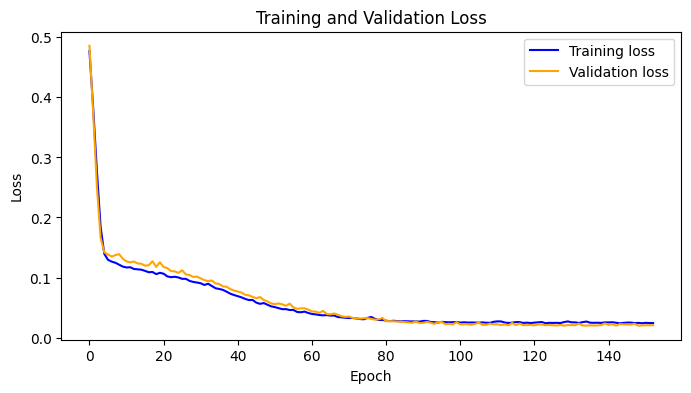

In [13]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Evaluation

In [14]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions = model(X_test)

In [15]:
# Calculate the mean absolute error
mae = metrics.mean_absolute_error(y_test, predictions)

# Print the mean absolute error
print("Mean Absolute Error:", mae.data)

Mean Absolute Error: 0.12858161


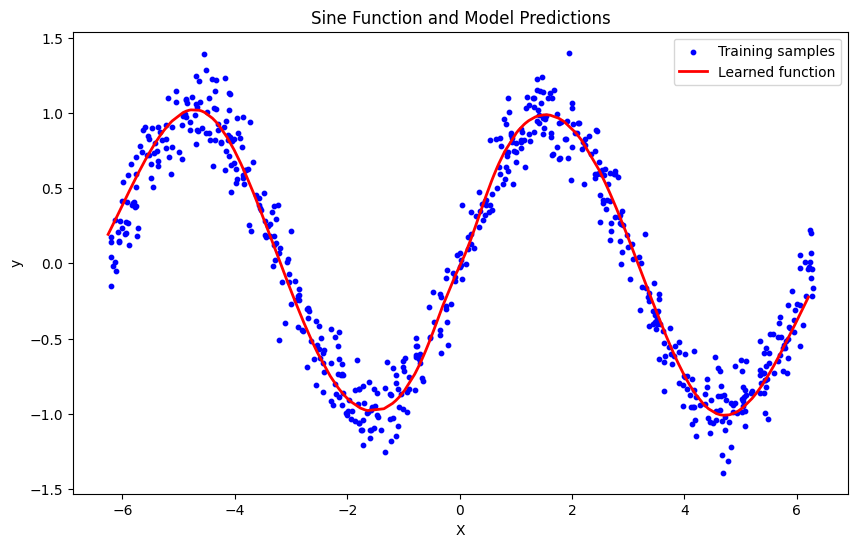

In [16]:
# Plot the sine function and the model predictions
data_analysis.plot_data(
    datasets = [
        {'points': np.array(list(zip(X_train.data, y_train.data))), 'label': "Training samples", 'color': "blue", 'size': 10, 'plot_type': 'scatter'},
        {'points': np.array(list(zip(X_test.data, predictions.data))), 'label': "Learned function", 'color': "red", 'plot_type': 'line'}
    ],
    title = "Sine Function and Model Predictions",
    xlabel = "X",
    ylabel = "y"
)